### This experiment compares the performance of a standard Graph Convolutional Network and a Curvature-based GCN (Curv-GCN) on two types of graph datasets: a homophilic graph (Cora) and a heterophilic graph (Chameleon).

**Goal** : evaluate whether incorporating Forman-Ricci curvature edge weights (in Curv-GCN) improves classification performance compared to a vanilla GCN that ignores edge weights.

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from matplotlib.colors import Normalize
from matplotlib import cm
from torch_geometric.datasets import WikipediaNetwork



In [3]:
dataset = Planetoid(root="/tmp/Cora", name="Cora", transform=T.NormalizeFeatures())
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges//2}, Features: {data.num_features}, Classes: {dataset.num_classes}")


Processing...


Dataset: Cora
Nodes: 2708, Edges: 5278, Features: 1433, Classes: 7


Done!


In [4]:
def forman_curvature(G):
    fc = {}
    for u, v in G.edges():
        triangles = len(list(nx.common_neighbors(G, u, v)))
        degree_sum = G.degree[u] + G.degree[v]
        curvature = max(0.1, 4 - degree_sum + 3 * triangles)
        fc[(u, v)] = curvature
    return fc

G = to_networkx(data, to_undirected=True)
forman = forman_curvature(G)
values = np.array(list(forman.values()))
print(f"Forman curvature stats > min:{values.min():.2f}, mean:{values.mean():.2f}, max:{values.max():.2f}")


Forman curvature stats > min:0.10, mean:0.33, max:7.00


/tmp/ipython-input-786816056.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


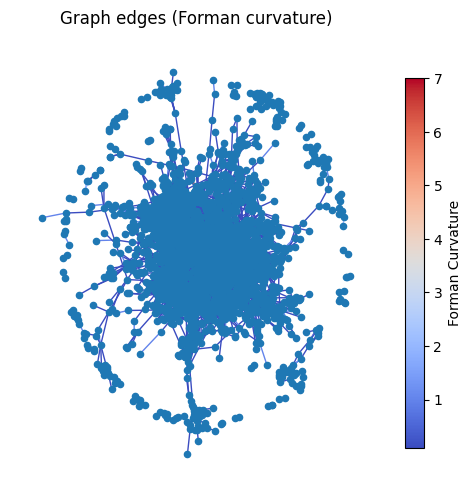

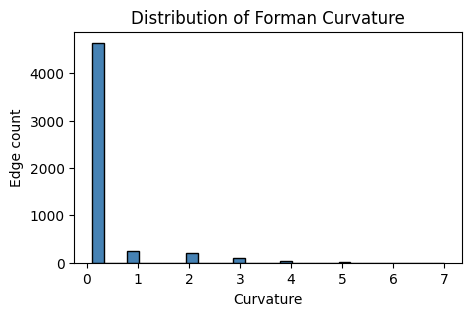

In [5]:
norm = Normalize(vmin=values.min(), vmax=values.max())
cmap = cm.get_cmap('coolwarm')
pos = nx.spring_layout(G, seed=42)
edge_colors = [cmap(norm(forman[(u, v)])) for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(
    G,
    pos,
    node_size=20,
    edge_color=edge_colors,
    width=1.0,
    ax=ax,
    with_labels=False,
)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("Forman Curvature", fontsize=10)

ax.set_title("Graph edges (Forman curvature)")
plt.show()


plt.figure(figsize=(5, 3))
plt.hist(values, bins=30, color="steelblue", edgecolor="k")
plt.title("Distribution of Forman Curvature")
plt.xlabel("Curvature")
plt.ylabel("Edge count")
plt.show()


In [6]:

edges = data.edge_index.t().tolist()
weights = torch.tensor(
    [forman.get(tuple(sorted(e)), 0.0) for e in edges],
    dtype=torch.float
)

weights = (weights - weights.min()) / (weights.max() - weights.min() + 1e-9)
weights = 0.1 + 0.9 * weights      # to avoid zero weights
data.edge_weight = weights


In [7]:
class CurvatureGCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [8]:
model = CurvatureGCN(dataset.num_features, 64, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

def test():
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append((pred[mask] == data.y[mask]).sum() / mask.sum())
    return accs, out

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        accs, _ = test()
        print(f"Epoch {epoch:03d} | Loss {loss:.3f} | Train {accs[0]:.3f} | Val {accs[1]:.3f} | Test {accs[2]:.3f}")


/tmp/ipython-input-3319619841.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss)


Epoch 020 | Loss 1.308 | Train 0.993 | Val 0.714 | Test 0.729
Epoch 040 | Loss 0.510 | Train 0.993 | Val 0.742 | Test 0.741
Epoch 060 | Loss 0.278 | Train 1.000 | Val 0.746 | Test 0.756
Epoch 080 | Loss 0.222 | Train 1.000 | Val 0.736 | Test 0.747
Epoch 100 | Loss 0.181 | Train 1.000 | Val 0.734 | Test 0.759
Epoch 120 | Loss 0.150 | Train 1.000 | Val 0.752 | Test 0.759
Epoch 140 | Loss 0.147 | Train 1.000 | Val 0.738 | Test 0.754
Epoch 160 | Loss 0.123 | Train 1.000 | Val 0.728 | Test 0.750
Epoch 180 | Loss 0.148 | Train 1.000 | Val 0.740 | Test 0.756
Epoch 200 | Loss 0.135 | Train 1.000 | Val 0.728 | Test 0.757


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:

def add_forman_edge_weights(data):

    G = to_networkx(data, to_undirected=True)
    forman = forman_curvature(G)
    edge_index = data.edge_index.cpu()
    num_edges = edge_index.shape[1]

    weights = []
    for i in range(num_edges):
        src, dst = edge_index[0, i].item(), edge_index[1, i].item()
        possible_keys = [
            (src, dst),
            (dst, src),
            tuple(sorted((src, dst))),
            (str(src), str(dst)),
            (str(dst), str(src)),
        ]

        weight = None
        for key in possible_keys:
            if key in forman:
                weight = forman[key]
                break
        if weight is None:
            weight = 0.1
            print(f" edge ({src},{dst}) not found in forman dict, using default {weight}")
        weights.append(weight)

    weights = torch.tensor(weights, dtype=torch.float)
    assert weights.size(0) == num_edges, \
        f"Weight tensor size ({weights.size(0)}) != num_edges ({num_edges})"

    w_min, w_max = weights.min(), weights.max()
    if w_max > w_min:
        weights = (weights - w_min) / (w_max - w_min)
        weights = 0.1 + 0.9 * weights
    else:
        weights = torch.full_like(weights, 0.5)
    data.edge_weight = weights
    return data


In [11]:

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, use_edge_weight=False):
        super().__init__()
        self.use_edge_weight = use_edge_weight
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, x, edge_index, edge_weight=None):
        if self.use_edge_weight and edge_weight is not None:
            x = self.conv1(x, edge_index, edge_weight)
        else:
            x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        if self.use_edge_weight and edge_weight is not None:
            x = self.conv2(x, edge_index, edge_weight)
        else:
            x = self.conv2(x, edge_index)
        return x


In [12]:

def train_model(model, data, optimizer, criterion, epochs=200):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()


In [13]:

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, getattr(data, 'edge_weight', None))
        pred = out.argmax(dim=1)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:
            correct = (pred[mask] == data.y[mask]).sum().item()
            total = mask.sum().item()
            acc = correct / total if total > 0 else 0.0
            accs.append(acc)
    return accs


In [14]:

def run_experiment(dataset_name, data, num_classes, num_runs=5):
    results = {'gcn': [], 'curv_gcn': []}

    for run in range(num_runs):
        # Vanilla GCN
        model = GCN(data.num_features, 64, num_classes, use_edge_weight=False).to(device)
        data_device = data.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()
        train_model(model, data_device, optimizer, criterion)
        _, _, test_acc = evaluate_model(model, data_device)
        results['gcn'].append(test_acc)

        # CurvGCN (fixed weights)
        data_curv = add_forman_edge_weights(data.clone())
        model_curv = GCN(data_curv.num_features, 64, num_classes, use_edge_weight=True).to(device)
        data_curv = data_curv.to(device)
        optimizer_curv = torch.optim.Adam(model_curv.parameters(), lr=0.01, weight_decay=5e-4)
        train_model(model_curv, data_curv, optimizer_curv, criterion)
        _, _, test_acc_curv = evaluate_model(model_curv, data_curv)
        results['curv_gcn'].append(test_acc_curv)

        print(f"[{dataset_name}] Run {run+1}/{num_runs} | GCN: {test_acc:.4f}, Curv-GCN: {test_acc_curv:.4f}")


    gcn_mean, gcn_std = np.mean(results['gcn']), np.std(results['gcn'])
    curv_mean, curv_std = np.mean(results['curv_gcn']), np.std(results['curv_gcn'])
    print(f"{dataset_name} Results (Test Accuracy)")
    print(f"GCN:          {gcn_mean:.4f} ± {gcn_std:.4f}")
    print(f"Curv-GCN:     {curv_mean:.4f} ± {curv_std:.4f}\n")

    return results


Training the GCN using Cora dataset (homophilic graph)

In [16]:
from torch_geometric.transforms import NormalizeFeatures

In [17]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# making sure masks exist for cora
if not hasattr(data, 'train_mask') or data.train_mask is None:
    n = data.num_nodes
    idx = torch.randperm(n)
    train_size = int(0.6 * n)
    val_size = int(0.2 * n)
    data.train_mask = torch.zeros(n, dtype=torch.bool)
    data.val_mask = torch.zeros(n, dtype=torch.bool)
    data.test_mask = torch.zeros(n, dtype=torch.bool)
    data.train_mask[idx[:train_size]] = True
    data.val_mask[idx[train_size:train_size + val_size]] = True
    data.test_mask[idx[train_size + val_size:]] = True

cora_results = run_experiment("Cora", data, dataset.num_classes)

[Cora] Run 1/5 | GCN: 0.8080, Curv-GCN: 0.7590
[Cora] Run 2/5 | GCN: 0.8060, Curv-GCN: 0.7590
[Cora] Run 3/5 | GCN: 0.8050, Curv-GCN: 0.7500
[Cora] Run 4/5 | GCN: 0.8080, Curv-GCN: 0.7530
[Cora] Run 5/5 | GCN: 0.8150, Curv-GCN: 0.7550
Cora Results (Test Accuracy)
GCN:          0.8084 ± 0.0035
Curv-GCN:     0.7552 ± 0.0035



Training the GCN using Chameleon dataset (Heterophilic graph)

In [18]:
dataset = WikipediaNetwork(root='/tmp/Chameleon', name='chameleon', transform=NormalizeFeatures())
data = dataset[0]


if hasattr(data, 'train_mask') and data.train_mask is not None:
    if data.train_mask.dim() == 2:
        split_idx = 0
        data.train_mask = data.train_mask[:, split_idx]
        data.val_mask = data.val_mask[:, split_idx]
        data.test_mask = data.test_mask[:, split_idx]
        print(f"  • using predefined split {split_idx}/10")
    else:
        print(f"  • u existing 1D masks")


print(f" train_mask shape: {data.train_mask.shape}")
print(f" val_mask shape: {data.val_mask.shape}")
print(f"  test_mask shape: {data.test_mask.shape}")
print(f"  train nodes: {data.train_mask.sum().item()}")
print(f"  val nodes: {data.val_mask.sum().item()}")
print(f" test nodes: {data.test_mask.sum().item()}")

cham_results = run_experiment("Chameleon", data, dataset.num_classes)

Processing...
Done!


  • using predefined split 0/10
 train_mask shape: torch.Size([2277])
 val_mask shape: torch.Size([2277])
  test_mask shape: torch.Size([2277])
  train nodes: 1092
  val nodes: 729
 test nodes: 456
[Chameleon] Run 1/5 | GCN: 0.3355, Curv-GCN: 0.4057
[Chameleon] Run 2/5 | GCN: 0.3289, Curv-GCN: 0.4079
[Chameleon] Run 3/5 | GCN: 0.3465, Curv-GCN: 0.4035
[Chameleon] Run 4/5 | GCN: 0.3355, Curv-GCN: 0.4123
[Chameleon] Run 5/5 | GCN: 0.3443, Curv-GCN: 0.4101
Chameleon Results (Test Accuracy)
GCN:          0.3382 ± 0.0064
Curv-GCN:     0.4079 ± 0.0031

